# TODOs

- filter books on valid ISBN, or try to correct them (at least trip some characters around)
- plot plot_groupby_stats() after normalization

# Reading in data

In [2]:
!wget http://www2.informatik.uni-freiburg.de/~cziegler/BX/BX-CSV-Dump.zip

--2021-11-05 14:05:04--  http://www2.informatik.uni-freiburg.de/~cziegler/BX/BX-CSV-Dump.zip
Resolving www2.informatik.uni-freiburg.de (www2.informatik.uni-freiburg.de)... 132.230.105.133
Connecting to www2.informatik.uni-freiburg.de (www2.informatik.uni-freiburg.de)|132.230.105.133|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26085508 (25M) [application/zip]
Saving to: ‘BX-CSV-Dump.zip.3’

BX-CSV-Dump.zip.3   100%[===================>]  24.88M  15.8MB/s    in 1.6s    

2021-11-05 14:05:08 (15.8 MB/s) - ‘BX-CSV-Dump.zip.3’ saved [26085508/26085508]



In [3]:
!unzip BX-CSV-Dump.zip

Archive:  BX-CSV-Dump.zip
replace BX-Book-Ratings.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: BX-Book-Ratings.csv     
replace BX-Books.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: BX-Books.csv            
replace BX-Users.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: BX-Users.csv            


In [3]:
import pandas as pd

In [4]:
users = pd.read_csv('BX-Users.csv')

ParserError: ignored

In [5]:
!head BX-Users.csv

"User-ID";"Location";"Age"
"1";"nyc, new york, usa";NULL
"2";"stockton, california, usa";"18"
"3";"moscow, yukon territory, russia";NULL
"4";"porto, v.n.gaia, portugal";"17"
"5";"farnborough, hants, united kingdom";NULL
"6";"santa monica, california, usa";"61"
"7";"washington, dc, usa";NULL
"8";"timmins, ontario, canada";NULL
"9";"germantown, tennessee, usa";NULL


In [6]:
users = pd.read_csv('BX-Users.csv', sep=';')

UnicodeDecodeError: ignored

In [7]:
users = pd.read_csv('BX-Users.csv', sep=';', encoding = "ISO-8859-1")
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [8]:
books = pd.read_csv('BX-Books.csv', sep=';', encoding = "ISO-8859-1")

ParserError: ignored

In [9]:
!head -n6452 BX-Books.csv | tail -n1

"0735201994";"Peterman Rides Again: Adventures Continue with the Real \"J. Peterman\" Through Life &amp; the Catalog Business";"John Peterman";"2000";"Prentice Hall Art";"http://images.amazon.com/images/P/0735201994.01.THUMBZZZ.jpg";"http://images.amazon.com/images/P/0735201994.01.MZZZZZZZ.jpg";"http://images.amazon.com/images/P/0735201994.01.LZZZZZZZ.jpg"


In [10]:
books = pd.read_csv('BX-Books.csv', sep=';', encoding = "ISO-8859-1", escapechar = "\\")
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [80]:
ratings = pd.read_csv('BX-Book-Ratings.csv', sep=';', encoding = "ISO-8859-1")
ratings.head(20)

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
5,276733,2080674722,0
6,276736,3257224281,8
7,276737,0600570967,6
8,276744,038550120X,7
9,276745,342310538,10


# Utility matrix - try no.1

In [ ]:
# do not try to run, you will run out of memory
# ratings_matrix = ratings.pivot(index='User-ID', columns='ISBN', values='Book-Rating').fillna(0)

In [12]:
ratings.shape

(1149780, 3)

In [13]:
from scipy.sparse import csr_matrix
from pandas.api.types import CategoricalDtype

In [14]:
sparce_matrix = csr_matrix((ratings['Book-Rating'], (ratings['User-ID'], ratings['ISBN'])))

TypeError: ignored

In [15]:
# inspired by https://stackoverflow.com/a/53235048
def create_matrix(frame, user_col, item_col, rating_col):
    """
    creates the sparse user-item interaction matrix

    Parameters
    ----------
    frame : DataFrame
        implicit rating data

    user_col : str
        user column name

    item_col : str
        item column name

    ratings_col : str
        implicit rating column name
    """

    user_c = CategoricalDtype(sorted(frame[user_col].unique()), ordered=True)
    item_c = CategoricalDtype(sorted(frame[item_col].unique()), ordered=True)

    row = frame[user_col].astype(user_c).cat.codes
    col = frame[item_col].astype(item_c).cat.codes
    return csr_matrix((frame[rating_col], (row, col)), \
                              shape=(user_c.categories.size, item_c.categories.size))

In [16]:
sparse_matrix = create_matrix(ratings, 'User-ID', 'ISBN', 'Book-Rating')
sparse_matrix

<105283x340556 sparse matrix of type '<class 'numpy.longlong'>'
	with 1149780 stored elements in Compressed Sparse Row format>

# Sanity checks


## Sparsity

In [17]:
len(ratings) / (len(users) * len(books))

1.5193415119518724e-05

very sparse => collaborative filtering might not be the best option

## New users and items

In [61]:
len(users['User-ID']) - len(ratings['User-ID'].unique())

173575

In [62]:
len(books['ISBN']) - len(ratings['ISBN'].unique())

-69177

In [73]:
len(books['ISBN'])

271379

In [69]:
books['ISBN'][books['ISBN'].isin(ratings['ISBN'])]

0         0195153448
1         0002005018
2         0060973129
3         0374157065
4         0393045218
             ...    
271374    0440400988
271375    0525447644
271376    006008667X
271377    0192126040
271378    0767409752
Name: ISBN, Length: 270170, dtype: object

In [74]:
len(books['ISBN']) - len(books['ISBN'][books['ISBN'].isin(ratings['ISBN'])])

1209

We don't have ratings for 1209 books.

In [76]:
len(ratings['ISBN'].unique())

340556

In [77]:
ratings['ISBN'][ratings['ISBN'].isin(books['ISBN'])].unique()

array(['034545104X', '0155061224', '0446520802', ..., '0590907301',
       '0679752714', '0806917695'], dtype=object)

In [79]:
len(ratings['ISBN'].unique()) - len(ratings['ISBN'][ratings['ISBN'].isin(books['ISBN'])].unique())

70386

We don't have metadata for 70 386 books that have some rating.

many new users and items => collaborative filtering might not be the best option

# Data analysis

## General look

In [82]:
users.head(20)

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN
5,6,"santa monica, california, usa",61.0
6,7,"washington, dc, usa",NaN
7,8,"timmins, ontario, canada",NaN
8,9,"germantown, tennessee, usa",NaN
9,10,"albacete, wisconsin, spain",26.0


In [83]:
users.describe()

,User-ID,Age
count,278858.00000,168096.000000
mean,139429.50000,34.751434
std,80499.51502,14.428097
min,1.00000,0.000000
25%,69715.25000,24.000000
50%,139429.50000,32.000000
75%,209143.75000,44.000000
max,278858.00000,244.000000


In [84]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


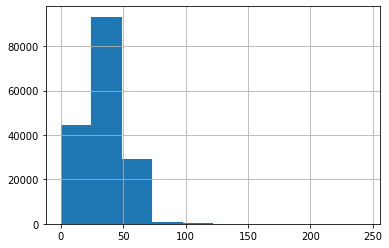

In [85]:
users['Age'].hist()

In [86]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [88]:
books = books[['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher']]

In [90]:
books.head(20)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company
5,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group
6,0425176428,What If?: The World's Foremost Military Histor...,Robert Cowley,2000,Berkley Publishing Group
7,0671870432,PLEADING GUILTY,Scott Turow,1993,Audioworks
8,0679425608,Under the Black Flag: The Romance and the Real...,David Cordingly,1996,Random House
9,074322678X,Where You'll Find Me: And Other Stories,Ann Beattie,2002,Scribner


## Groupby

In [118]:
import matplotlib.pyplot as plt

def plot_groupby_stats(ratings):

  avg_user_rating = ratings.groupby('User-ID')["Book-Rating"].mean()
  num_ratings_by_user = ratings.groupby('User-ID')["Book-Rating"].count()
  avg_book_rating = ratings.groupby('ISBN')["Book-Rating"].mean()
  num_ratings_by_book = ratings.groupby('ISBN')["Book-Rating"].count()

  n_rows = 2
  n_cols = 2
  fig=plt.figure()

  ax = fig.add_subplot(n_rows, n_cols, 1)
  avg_user_rating.hist(ax=ax)
  ax.set_title("Average user rating")

  ax = fig.add_subplot(n_rows, n_cols, 2)
  num_ratings_by_user.hist(ax=ax)
  ax.set_title("Number of ratings by user")

  ax = fig.add_subplot(n_rows, n_cols, 3)
  avg_book_rating.hist(ax=ax)
  ax.set_title("Average book rating")

  ax = fig.add_subplot(n_rows, n_cols, 4)
  num_ratings_by_book.hist(ax=ax)
  ax.set_title("Number of ratings by book")

  fig.tight_layout()  # Improves appearance a bit.
  plt.show()


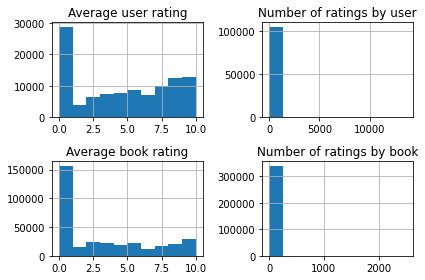

In [119]:
plot_groupby_stats(ratings)